# Chapters 17: Dimensionality Reduction

In [2]:
# Basic Libraries

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

import pandas as pd
import numpy as np

### The Dataset

In [4]:
# Titanic Dataset

url = ("https://raw.githubusercontent.com/joanby/python-ml-course/refs/heads/master/datasets/titanic/titanic3.csv")
df = pd.read_csv(url)
orig_df = df
orig_df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


Here is a summary of all dataset treatments; for more details, see MLPR 01 and MLPR 02.

In [6]:
from sklearn import model_selection 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer  
from sklearn.preprocessing import StandardScaler 

def tweak_titanic(df):
    # Drop unnecessary columns and convert categorical columns to dummy variables
    df = df.drop(
        columns=[
            "name",          # Drop passenger name column
            "ticket",        # Drop ticket column
            "home.dest",     # Drop home destination column
            "boat",          # Drop boat information column
            "body",          # Drop body number column
            "cabin",         # Drop cabin information column
        ]
    ).pipe(pd.get_dummies, drop_first=True)  # Convert categorical variables to dummy variables, dropping the first category
    return df                                # Return the cleaned and transformed DataFrame

def get_train_test_X_y(
    df, y_col, size=0.3, std_cols=None
):
    y = df[y_col]               # Extract the target variable
    X = df.drop(columns=y_col)  # Drop target variable from feature set
    
    X_train, X_test, y_train, y_test = model_selection.train_test_split(   # Split data into training and test sets
        X, y, test_size=size, random_state=42
    )
    cols = X.columns  # Get list of feature columns
    
    num_cols = [      # List of numeric columns to impute for missing values
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare",
    ]
    fi = IterativeImputer()                       # Initialize IterativeImputer for imputing missing values
    fitted = fi.fit_transform(X_train[num_cols])  # Fit and transform imputer on training numeric columns
    
    # Update training DataFrame with imputed values for numeric columns
    X_train = X_train.assign(**{c: fitted[:, i] for i, c in enumerate(num_cols)})
    test_fit = fi.transform(X_test[num_cols])  # Transform test data using the same imputer
    
    # Update test DataFrame with imputed values for numeric columns
    X_test = X_test.assign(**{c: test_fit[:, i] for i, c in enumerate(num_cols)})
    
    # Standardize specified columns if any are provided
    if std_cols:
        std = StandardScaler()  # Initialize StandardScaler
        fitted = std.fit_transform(X_train[std_cols])  # Fit and transform scaler on training standardization columns
        # Update training DataFrame with standardized values
        X_train = X_train.assign(**{c: fitted[:, i] for i, c in enumerate(std_cols)})
        test_fit = std.transform(X_test[std_cols])     # Transform test data using the same scaler
        # Update test DataFrame with standardized values
        X_test = X_test.assign(**{c: test_fit[:, i] for i, c in enumerate(std_cols)})

    # Return training and test sets for features and target
    return X_train, X_test, y_train, y_test

# Apply the functions to preprocess the Titanic dataset
ti_df = tweak_titanic(orig_df)                 # Clean and transform the original DataFrame
std_cols = "pclass,age,sibsp,fare".split(",")  # Specify columns to standardize

# Split the preprocessed data into training and test sets
X_train, X_test, y_train, y_test = get_train_test_X_y(
    ti_df, "survived", std_cols=std_cols
)

# Concatenate training and test sets for features and target variables for further use
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

### PCA

Principal Component Analysis (PCA) takes a matrix (X) of rows (samples) and columns (features). PCA returns a new matrix that has columns that are linear combinations of the original columns. These linear combinations maximize the variance. Each column is orthogonal (a right angle) to the other columns. The columns are sorted in order of decreasing variance.

PCA is useful to visualize data in two (or three) dimensions. It is also used as a preprocessing step to filter out random noisein data. It is good for finding global structures, but not local ones, and works well with linear data.

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(random_state=42)             # Initialize the PCA object with a fixed random state for reproducibility

X_pca = pca.fit_transform(             # Apply PCA to the scaled data and transform it to principal components
    StandardScaler().fit_transform(X)  # Scale the data to standardize features before applying PCA
)

pca.explained_variance_ratio_          # Output the explained variance ratio for each principal component

array([0.23922833, 0.21616852, 0.1923158 , 0.10464906, 0.08154798,
       0.0727221 , 0.05130716, 0.04206106])

    The first principal component explains approximately 23.92% of the total variance in the dataset.
    The second principal component explains approximately 21.62% of the variance.
    The third principal component explains approximately 19.23% of the variance.
    The fourth principal component explains approximately 10.46% of the variance.
    The fifth principal component explains approximately 8.15% of the variance.
    The sixth principal component explains approximately 7.27% of the variance.
    The seventh principal component explains approximately 5.13% of the variance.
    The eighth principal component explains approximately 4.21% of the variance.

In [10]:
# The first principal component's coefficients for each feature in the original space
pca.components_[0]

array([ 0.63274158, -0.39602155, -0.00653644, -0.11500363, -0.58150304,
        0.19764921,  0.20422298,  0.10304588])

Each value corresponds to a feature in the original dataset, and the number indicates the weight or contribution of that feature to the first principal component. 

* Positive or negative values indicate the direction of the relationship:

`Positive values (e.g., 0.63274158)` mean that as the feature increases, it contributes positively to the variance captured by this component.

`Negative values (e.g., -0.39602155)` mean that as the feature increases, it contributes negatively to the variance.

* Magnitude (absolute value) indicates the strength of the contribution:
 
`Larger absolute values (e.g., 0.63274158 or -0.58150304)` suggest that these features are more significant in defining this principal component.

`Smaller absolute values (e.g., -0.00653644)` indicate a lesser influence of those features on this component.

#### Interpretation: 
The first principal component is a weighted combination of your original features. The features with the highest absolute values contribute most to explaining the variance captured by this component. Features with small coefficients have less influence on this particular component's variance explanation.

### Scree Plot

Plotting the cumulative sum of the explained variance ratio is called a scree plot. It will show how much
information is stored in the components. You can use the elbow method to see if it bends to determine how many components to use:

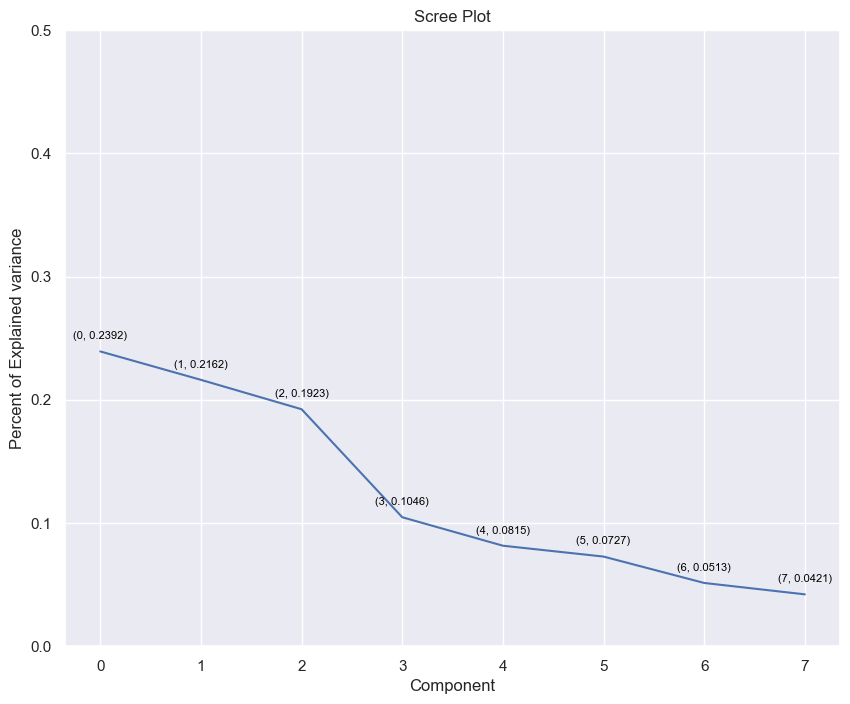

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))       # Create a figure and an axis with a specified size for the plot
ax.plot(pca.explained_variance_ratio_)        # Plot the explained variance ratio for each principal component
ax.set(                                       # Set properties for the plot:
    xlabel="Component",                       # Label for the x-axis as "Component"
    ylabel="Percent of Explained variance",   # Label for the y-axis as "Percent of Explained variance"
    title="Scree Plot",                       # Title of the plot as "Scree Plot"
    ylim=(0, 0.5),                            # Set the y-axis limits from 0 to 0.5 to represent percentages
)

# Annotate important points on the plot
for i in range(len(pca.explained_variance_ratio_)):
    ax.text(
        i,                                                 # x-coordinate for the text
        pca.explained_variance_ratio_[i] + 0.01,           # y-coordinate slightly above the point for visibility
        f"({i}, {pca.explained_variance_ratio_[i]:.4f})",  # Display formatted text with component index and value
        color='black',                                     # Set the text color to black
        ha='center',                                       # Center align the text above the point
        fontsize=8                                         # Set the font size to make the text smaller
    );

`X-Axis (Component)`: This represents the principal components, starting from the first (0) to the last (7) component.

`Y-Axis (Percent of Explained Variance)`: This shows the proportion of the total dataset variance that each principal component explains.

`Line Plot`: The plot shows how much variance is explained by each principal component, decreasing as you move to higher-order components.

`First Component`: The first principal component explains the largest amount of variance (around 23.9%, as shown in your previous output). 

There appears to be an "elbow" at the second or third component, indicating that adding more components beyond this point contributes significantly less to explaining the variance. This suggests that using only the first few components might be sufficient for dimensionality reduction without losing much information.

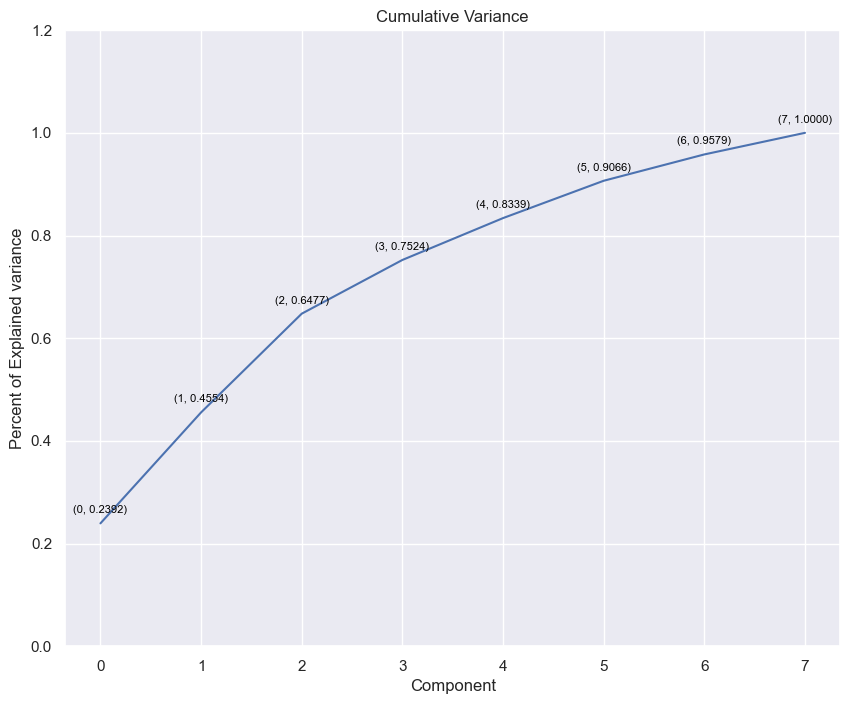

In [16]:
# Cumulative Plot
fig, ax = plt.subplots(figsize=(10, 8))      # Create a figure and an axes object with a specified size (6x4 inches)
ax.plot(                                     # Plot on the axes object
    np.cumsum(pca.explained_variance_ratio_) # Plot the cumulative sum of the explained variance ratio from PCA
)
ax.set(                                      # Set the properties for the axes
    xlabel="Component",                      # Label the x-axis as 'Component'
    ylabel="Percent of Explained variance",  # Label the y-axis as 'Percent of Explained variance'
    title="Cumulative Variance",             # Set the title of the plot as 'Cumulative Variance'
    ylim=(0, 1.2),                            # Set the y-axis limits from 0 to 1 to represent percentage
)

# Annotate important points with small text
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
for i in range(len(cumulative_variance)):
    ax.text(
        i,                                   # x-coordinate for the text
        cumulative_variance[i] + 0.02,       # y-coordinate slightly above the point for visibility
        f"({i}, {cumulative_variance[i]:.4f})",  # Display formatted text with component index and value
        color='black',                       # Set the text color to black
        ha='center',                         # Center align the text above the point
        fontsize=8                           # Set the font size to make the text smaller
    );

    The x-axis shows the number of components included in the analysis (from 0 to 7).

    The y-axis represents the cumulative percentage of the total variance in the data that is explained by those components.

    Each point on the plot indicates how much of the total variance is captured when adding that many principal components.

How much do features impact components? Use the matplotlib `imshow` function to plot the components along the x axis and
the original features along the y axis. The darker the color, the more the original column contributes to the component.

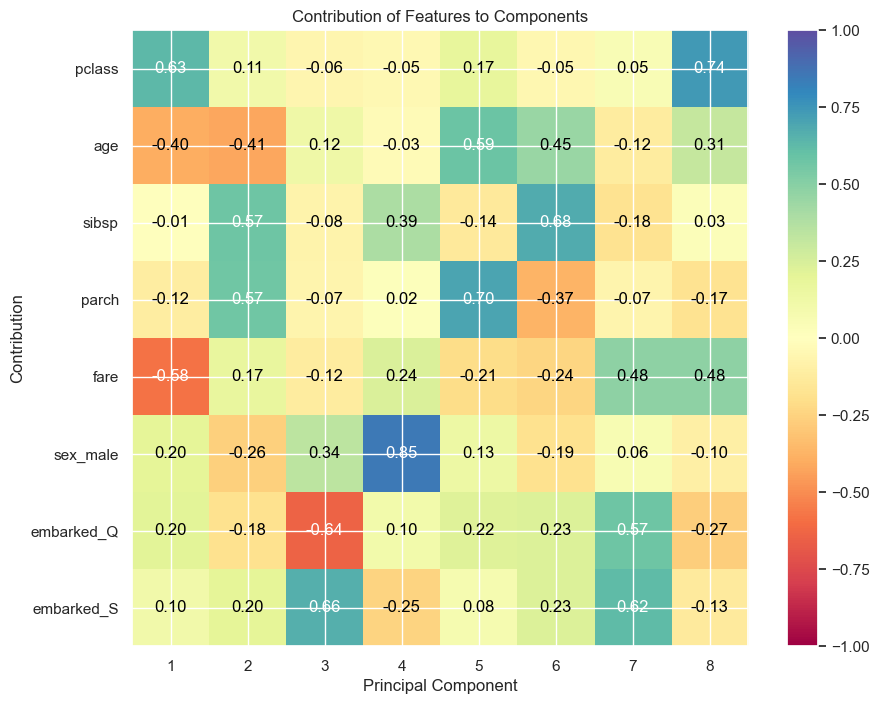

In [19]:
fig, ax = plt.subplots(figsize=(10, 8)) # Create a figure and an axis with a specified size (6x4 inches)
im = plt.imshow(                        # Display an image representation of the PCA component matrix
    pca.components_.T,                  # Transpose of PCA components to show features as rows and components as columns
    cmap="Spectral",                    # Use the 'Spectral' colormap for color representation
    vmin=-1,                            # Set the minimum value for the colormap scale to -1
    vmax=1,                             # Set the maximum value for the colormap scale to 1
)

# Add text annotations inside each cell of the heatmap
for i in range(pca.components_.shape[1]):     # Iterate over each component (column)
    for j in range(pca.components_.shape[0]): # Iterate over each feature (row)
        text = f"{pca.components_[i, j]:.2f}" # Format the value with 2 decimal places
        ax.text(                              # Place the text in the middle of each cell
            i, j, text, 
            ha='center', va='center', 
            color='black' if abs(pca.components_[i, j]) < 0.5 else 'white'  # Adjust text color for contrast
        )

plt.yticks(                                   # Set y-ticks for the plot
    range(len(X.columns)),                    # Generate y-tick positions based on the number of features
    X.columns                                 # Label each y-tick with the corresponding feature name
)
plt.xticks(                                   # Set x-ticks for the plot
    range(8),                                 # Generate x-tick positions for the first 8 components
    range(1, 9)                               # Label each x-tick starting from 1 to 8
)
plt.xlabel("Principal Component")             # Label the x-axis as 'Principal Component'
plt.ylabel("Contribution")                    # Label the y-axis as 'Contribution'
plt.title(                                    # Set the title of the plot
    "Contribution of Features to Components"
)
plt.colorbar(im);                             # Display a color bar to show the scale of contributions

An alternative view is to look at a bar plot. Each component is shown with the contributions from the original data:

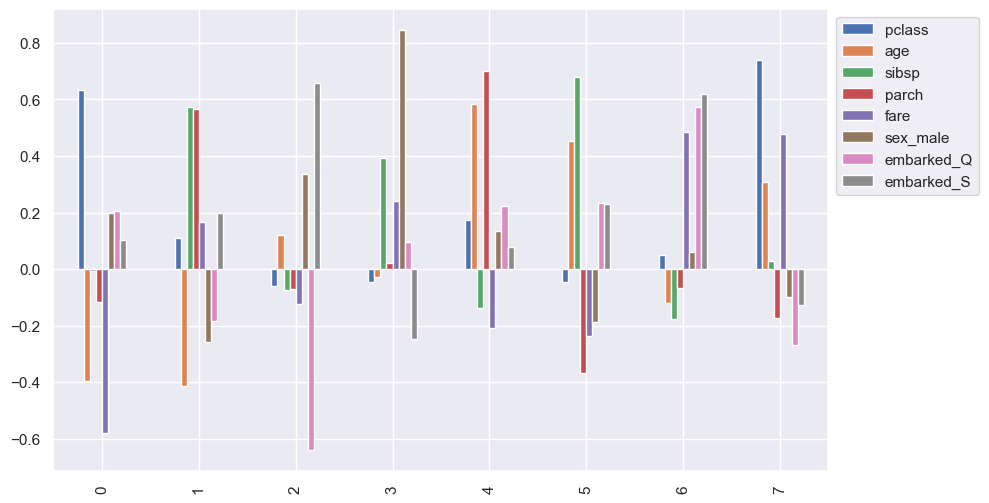

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))  # Create a figure and an axis with a size of 10x6 inches

pd.DataFrame(                            # Create a DataFrame from PCA components
    pca.components_, columns=X.columns   # Use PCA components as data and feature names as columns
).plot(                                  # Plot the DataFrame
    kind="bar",                          # Plot type is set to 'bar'
    ax=ax                                # Plot on the previously created axis
).legend(                                # Customize the legend
    bbox_to_anchor=(1, 1)                # Position the legend outside the plot, at the top-right corner
);

If we have many features, we may want to limit the plots above by showing only features that meet a minimum weight. Here is
code to find all the features in the first two components that have absolute values of at least .5:

In [23]:
comps = pd.DataFrame(                    # Create a DataFrame to hold PCA components
    pca.components_, columns=X.columns   # Assign PCA components as data and feature names as columns
)
min_val = 0.5                            # Set a threshold value to filter significant component contributions
num_components = 2                       # Define the number of principal components to evaluate
pca_cols = set()                         # Initialize an empty set to store the feature names

for i in range(num_components):          # Iterate over the specified number of principal components
    parts = comps.iloc[i][               # Select the component values for the i-th principal component
        comps.iloc[i].abs() > min_val    # Filter component values with an absolute value greater than min_val
    ]
    pca_cols.update(set(parts.index))    # Add the feature names (indices) that meet the condition to pca_cols

pca_cols                                 # Display the set of feature names that contribute significantly to the components

{'fare', 'parch', 'pclass', 'sibsp'}

PCA is commonly used to visualize high dimension datasets in two components. Here we visualize the Titanic features in 2D.
They are colored by survival status. Sometimes clusters may appear in the visualization. In this case, there doesn’t appear to be clustering of survivors.

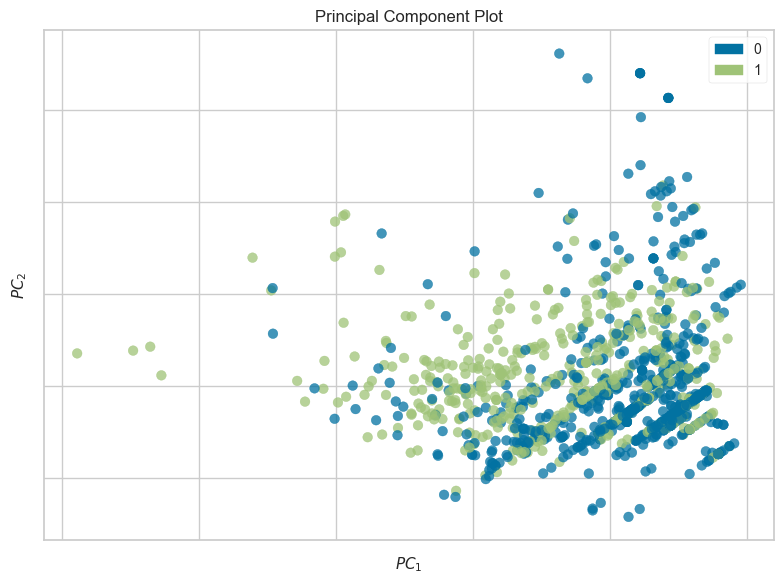

In [25]:
from yellowbrick.features.pca import PCADecomposition

fig, ax = plt.subplots(figsize=(8, 6))   # Create a figure and an axis with a specified size (8x6 inches)
colors = ["rg"[j] for j in y]            # Generate a list of colors 'r' or 'g' based on the values in y
pca_viz = PCADecomposition(color=colors) # Initialize a PCA visualization object with the color scheme
pca_viz.fit_transform(X, y)              # Fit the PCA model to the data and transform it for visualization
pca_viz.poof();                          # Render and display the PCA plot

If you want to color the scatter plot by a column and add a legend (not a colorbar), you need to loop over each color and plot
that group individually in pandas or matplotlib (or use seaborn). Below we also set the aspect ratio to the ratio of the
explained variances for the components we are looking at. Because the second component only has 90% of the first component, it is a little shorter.

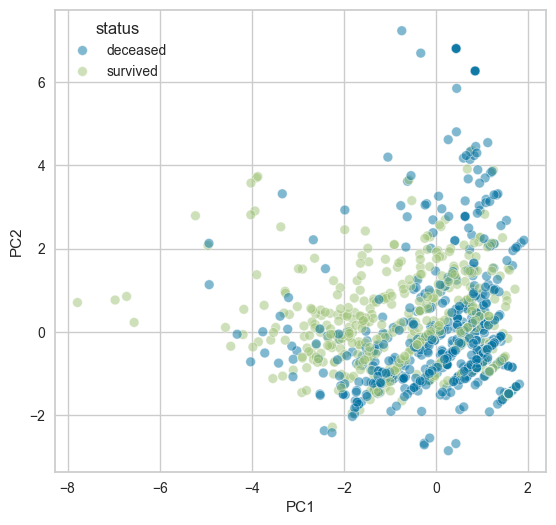

In [27]:
fig, ax = plt.subplots(figsize=(8, 6))  # Create a figure and an axis with a specified size (8x6 inches)

pca_df = pd.DataFrame(                  # Create a DataFrame from the PCA-transformed data
    X_pca,                              # Use the PCA-transformed data as the DataFrame's values
    columns=[                           # Name the columns as 'PC1', 'PC2', etc.
        f"PC{i+1}"                      # Create column names in the format 'PC1', 'PC2', etc.
        for i in range(X_pca.shape[1])  # Iterate over the number of components in the PCA data
    ],
)
pca_df["status"] = [("deceased", "survived")[i] for i in y]  # Add a 'status' column based on the y values

evr = pca.explained_variance_ratio_     # Store the explained variance ratio of the PCA components

ax.set_aspect(evr[1] / evr[0])          # Set the aspect ratio of the plot based on the variance ratio of PC1 and PC2

sns.scatterplot(                        # Create a scatter plot with seaborn
    x="PC1",                            # Set the x-axis to 'PC1'
    y="PC2",                            # Set the y-axis to 'PC2'
    hue="status",                       # Color the points based on the 'status' column
    data=pca_df,                        # Use the PCA DataFrame as the data source
    alpha=0.5,                          # Set the transparency of the points to 0.5
    ax=ax,                              # Plot on the previously created axis
);

Below, we augment the scatter plot by showing a loading plot on top of it. This plot is called a biplot because it has the scatter
plot and the loadings. The loadings indicate how strong features are and how they correlate. If their angles are close, they likely correlate. If the angles are at 90 degrees, they likely don’t correlate. Finally, if the angle between them is close to 180 degrees, they have a negative correlation:

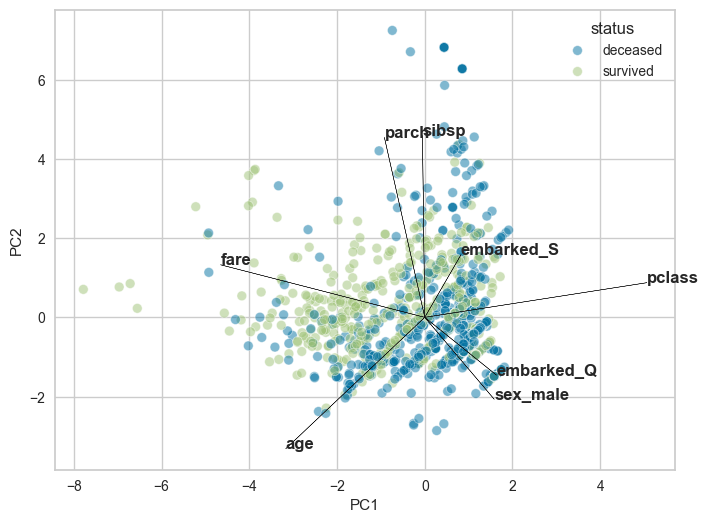

In [29]:
fig, ax = plt.subplots(figsize=(8, 6))  # Create a figure and an axis with a specified size (8x6 inches)

pca_df = pd.DataFrame(                  # Create a DataFrame from the PCA-transformed data
    X_pca,                              # Use the PCA-transformed data as the DataFrame's values
    columns=[f"PC{i+1}" for i in range(X_pca.shape[1])],  # Name the columns as 'PC1', 'PC2', etc.
)

pca_df["status"] = [                    # Add a 'status' column to the DataFrame
    ("deceased", "survived")[i] for i in y  # Map values in 'y' to 'deceased' or 'survived'
]

evr = pca.explained_variance_ratio_     # Store the explained variance ratio of the PCA components

x_idx = 0  # x_pc                        # Index for the x-axis principal component (PC1)
y_idx = 1  # y_pc                        # Index for the y-axis principal component (PC2)

ax.set_aspect(evr[y_idx] / evr[x_idx])  # Set the aspect ratio of the plot based on the variance ratio of the selected components

x_col = pca_df.columns[x_idx]           # Get the column name for the x-axis (e.g., 'PC1')
y_col = pca_df.columns[y_idx]           # Get the column name for the y-axis (e.g., 'PC2')

sns.scatterplot(                        # Create a scatter plot with seaborn
    x=x_col,                            # Set the x-axis to the selected PC
    y=y_col,                            # Set the y-axis to the selected PC
    hue="status",                       # Color the points based on the 'status' column
    data=pca_df,                        # Use the PCA DataFrame as the data source
    alpha=0.5,                          # Set the transparency of the points to 0.5
    ax=ax,                              # Plot on the previously created axis
)

scale = 8                               # Set a scaling factor for the arrows representing feature contributions

comps = pd.DataFrame(                   # Create a DataFrame for the PCA components
    pca.components_, 
    columns=X.columns                   # Name the columns using the original feature names
)

for idx, s in comps.T.iterrows():       # Iterate over each feature and its contributions to the components
    plt.arrow(                          # Draw an arrow starting from the origin
        0,                              # x-coordinate of the arrow start
        0,                              # y-coordinate of the arrow start
        s[x_idx] * scale,               # x-coordinate for the arrow end, scaled by 'scale'
        s[y_idx] * scale,               # y-coordinate for the arrow end, scaled by 'scale'
        color="k",                      # Set arrow color to black ('k')
    )
    plt.text(                           # Add text to indicate the feature name at the arrow end
        s[x_idx] * scale,               # x-coordinate for the text position
        s[y_idx] * scale,               # y-coordinate for the text position
        idx,                            # Feature name to display
        weight="bold",                  # Make the text bold
    )

From previous tree models, we know that age, fare, and sex are important for determining whether a passenger survived. The
first principal component is influenced by pclass, age, and fare, while the fourth is influenced by sex. Let’s plot those components against each other.
    
Again, this plot is scaling the aspect ratio of the plot based on the ratios of variance of the components.

This plot appears to more accurately separate the survivors:

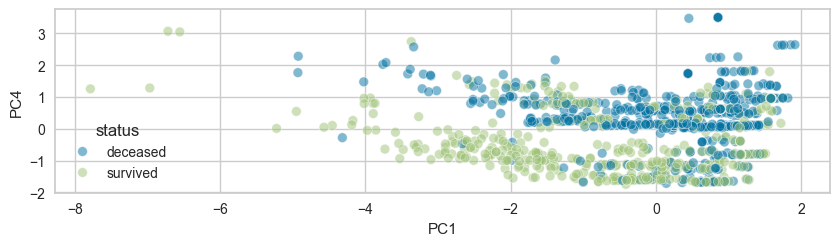

In [31]:
fig, ax = plt.subplots(figsize=(10, 8))  # Create a figure and an axis object with a size of 10x8 inches

pca_df = pd.DataFrame(                   # Create a DataFrame to hold the PCA-transformed data
    X_pca,                               # Use the PCA-transformed data as the DataFrame values
    columns=[f"PC{i+1}" for i in range(X_pca.shape[1])],  # Set column names as 'PC1', 'PC2', etc.
)

pca_df["status"] = [                     # Add a 'status' column to the DataFrame
    ("deceased", "survived")[i] for i in y  # Map the values in 'y' to 'deceased' or 'survived'
]

evr = pca.explained_variance_ratio_      # Store the explained variance ratio for each principal component

ax.set_aspect(evr[3] / evr[0])           # Set the aspect ratio of the plot based on the variance ratio of PC4 and PC1

sns.scatterplot(                         # Create a scatter plot with seaborn
    x="PC1",                             # Set the x-axis to 'PC1'
    y="PC4",                             # Set the y-axis to 'PC4'
    hue="status",                        # Color the points based on the 'status' column
    data=pca_df,                         # Use the PCA DataFrame as the data source
    alpha=0.5,                           # Set the transparency of the points to 0.5 for better visualization
    ax=ax,                               # Plot on the previously created axis
);

This scatter plot represents the distribution of data points based on their projections on the first principal component (PC1) and the fourth principal component (PC4) from a PCA analysis. Each point on the plot corresponds to a data instance, and the color indicates its category, with blue representing "deceased" and green representing "survived."

    X-axis (PC1): Represents the first principal component, which explains the most variance in the data.
    Y-axis (PC4): Represents the fourth principal component, which captures a portion of the variance not accounted for by the first three components.

Each point represents a data instance, with colors indicating the "status" of the instance (either "deceased" or "survived").

    Separation Between Classes: The distribution shows that there is some separation between the "deceased" (blue) and "survived" (green) groups, especially along the PC1 axis. This indicates that PC1 contributes to distinguishing between the two categories.

Overall, this plot suggests that while PC1 plays a more prominent role in separating the classes, PC4 also adds some level of differentiation, helping to spread the points along the Y-axis for additional insights into class variance. This kind of visualization helps identify how well PCA components separate or cluster data based on categories, useful in understanding feature contributions and variance distributions in the data.

In [33]:
from bokeh.io import output_notebook  
from bokeh import models, palettes, transform  
from bokeh.plotting import figure, show  

def bokeh_scatter(    # Define a function to create a scatter plot using Bokeh
    x,                # x-axis column name
    y,                # y-axis column name
    data,             # DataFrame containing data to be plotted
    hue=None,         # Column name for coloring the points
    label_cols=None,  # Columns to be used in tooltips (default is all columns)
    size=None,        # Size of the points
    legend=None,      # Column name to be used for legend
    alpha=0.5,        # Transparency level for the points
):
    """
    x - x column name to plot
    y - y column name to plot
    data - pandas DataFrame
    hue - column name to color by (numeric)
    legend - column name to label by
    label_cols - columns to use in tooltip (None = all in DataFrame)
    size - size of points in screen space units
    alpha - transparency
    """
    output_notebook()   # Display Bokeh plots directly in the Jupyter Notebook
    
    circle_kwargs = {}  # Initialize a dictionary to store keyword arguments for the circle plot
    
    if legend:                                  # Check if legend is specified
        circle_kwargs["legend_field"] = legend  # Use 'legend_field' for specifying the column for legends
    
    if size:                          # Check if size is specified
        circle_kwargs["size"] = size  # Set the size of the points
    
    if hue:                                 # Check if hue is specified for coloring
        color_seq = data[hue]               # Extract the column to be used for color mapping
        mapper = models.LinearColorMapper(  # Create a color mapper for the hue
            palette=palettes.viridis(256),  # Use the 'viridis' color palette with 256 colors
            low=min(color_seq),             # Minimum value for color scaling
            high=max(color_seq),            # Maximum value for color scaling
        )
        circle_kwargs["fill_color"] = transform.transform(hue, mapper)  # Set the fill color using the mapper
    
    ds = models.ColumnDataSource(data)      # Create a Bokeh data source from the DataFrame
    
    if label_cols is None:         # Check if label columns are not specified
        label_cols = data.columns  # Use all columns if label_cols is None
    
    tool_tips = sorted(                              # Create a sorted list of tooltips
        [(x, "@{}".format(x)) for x in label_cols],  # Format each label column for tooltips
        key=lambda tup: tup[0],                      # Sort tooltips by the column name
    )
    
    hover = models.HoverTool(tooltips=tool_tips)     # Create a hover tool with the specified tooltips
    
    fig = figure(                                              # Create a Bokeh figure object
        tools=[hover, "pan", "zoom_in", "zoom_out", "reset"],  # Add tools for interaction
        toolbar_location="below",                              # Place the toolbar below the plot
    )
    
    fig.circle(          # Add a circle plot to the figure
        x,               # x-axis data
        y,               # y-axis data
        source=ds,       # Data source for the plot
        alpha=alpha,     # Set the transparency
        **circle_kwargs  # Pass additional keyword arguments
    )
    
    show(fig)   # Display the plot
    return fig  # Return the plot object

# Call the function to create and display a scatter plot
res = bokeh_scatter(
    "PC1",          # x-axis column
    "PC2",          # y-axis column
    data=pca_df.assign(surv=y.reset_index(drop=True)),  # Add 'surv' column to DataFrame for coloring
    hue="surv",     # Column for color mapping
    size=10,        # Size of points
    legend="surv",  # Column for legend
)

Loading BokehJS ...

Another tool: `mpl_toolkits.mplot3d`

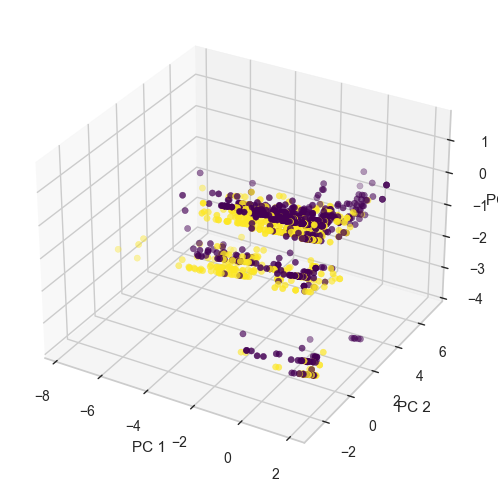

In [35]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))            # Create a figure with a specified size (8x6 inches)
ax = fig.add_subplot(111, projection="3d")  # Add a 3D subplot to the figure

# Create a 3D scatter plot
ax.scatter(
    xs=X_pca[:, 0],  # X-coordinates (values from the first principal component)
    ys=X_pca[:, 1],  # Y-coordinates (values from the second principal component)
    zs=X_pca[:, 2],  # Z-coordinates (values from the third principal component)
    c=y,             # Color the points based on the 'y' target variable
    cmap="viridis",  # Use the 'viridis' colormap for color mapping
)

# Set labels for the axes
ax.set_xlabel("PC 1")   # Label the x-axis as 'PC 1'
ax.set_ylabel("PC 2")   # Label the y-axis as 'PC 2'
ax.set_zlabel("PC 3");  # Label the z-axis as 'PC 3' and add a semicolon to suppress additional output